In [102]:
import pandas as pd
import numpy as np

import collections
import torch
import pickle
import time
import json
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from  gensim.models import KeyedVectors
from featurization import word2vec, featurizer
import model as m
from featurizer import ChungusSet 
from torch.utils.data import DataLoader
import geopy
from geopy.distance import geodesic
import constants
from torch.utils.data import Dataset

In [2]:
# load word embeddings
def load_embedding():
    # load word2vec weights
    EpochSaver = word2vec.EpochSaver
    w2v = KeyedVectors.load_word2vec_format('./models/word2vec.model')

    weights = torch.FloatTensor(w2v.vectors)
    embedding = nn.Embedding.from_pretrained(weights)

    return embedding

embedding = load_embedding()

INFO - 01:45:32: loading projection weights from ./models/word2vec.model
INFO - 01:46:10: loaded (126352, 300) matrix from ./models/word2vec.model


In [20]:
# load model
path = "epoch_74.model"
model = m.Classifier(embedding)
model = nn.DataParallel(model, device_ids=[0,1,2,3,4,5,6,7])
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to("cuda:0")
batch_size = 256

In [33]:
def evaluate_model(model):
    test_set = pickle.load(open("data/test_set.p", "rb"))
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,num_workers=30, drop_last=True)
    print("Test set of %d entries" % len(test_set))
    
    y_pred = []
    l = []
    
    err=0
    tot = 0
    with torch.no_grad():
        i = 0
        for (words, subs, times, labels) in test_loader:
            # remove subs, see how model does
            # subs = torch.zeros(batch_size, 5000)   
            
            output = model(words, subs, times, labels)
            
            print(output.size())
            # let the maximum index be our predicted class
            _, yh = torch.max(output, 1)
            
            l += list(labels)
            y_pred += output.tolist()
            
            tot += labels.size(0)
            
            i+=1
            if(i % 10 == 0):
                print("Iteration: %d, processed %d labels" % (i, tot))
                print(labels.size())
            
            ## add to err number of missclassification, i.e. number of indices that
            ## yh and y are not equal
            ## note that y and yh are vectors of size = batch_size = (256 in our case)
            err += sum(list(map(lambda i: 1 if labels[i] != yh[i] else 0, range(len(labels)))))

    print('Accuracy of FC prediction on test users: %5.2f%%' % (100-100 * err / tot))
    
    return (y_pred, l)

In [34]:
y_pred, l = evaluate_model(model)

Test set of 10755 entries
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
Iteration: 10, processed 2560 labels
torch.Size([256])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
Iteration: 20, processed 5120 labels
torch.Size([256])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
Iteration: 30, processed 7680 labels
torch.Size([256])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 

In [65]:
print(len(y_pred))
print(len(l))

def maxN(elements, n):
    return sorted(elements, reverse=True)[:n]

tops = np.zeros(51)

for i in range(len(y_pred)):
    p = y_pred[i]
    label = l[i].item()
    
    # sort indices to get most common state
    indices = list(range(len(p)))
    indices.sort(key = lambda i: p[i], reverse=True)
    
    # get position of this index
    pos = indices.index(label)
    # increment everything at pos and after
    for j in range(pos, 51):
        tops[j] +=1
    

10752
10752


[ 6424.  7453.  7914.  8198.  8389.  8538.  8684.  8798.  8924.  9028.
  9118.  9201.  9279.  9351.  9413.  9497.  9562.  9615.  9665.  9719.
  9758.  9817.  9860.  9902.  9944.  9994. 10035. 10085. 10121. 10172.
 10215. 10246. 10277. 10308. 10337. 10367. 10403. 10439. 10468. 10497.
 10528. 10549. 10585. 10603. 10623. 10646. 10665. 10683. 10705. 10736.
 10752.]
[0, 0.5974702380952381, 0.6931733630952381, 0.7360491071428571, 0.7624627976190477, 0.7802269345238095, 0.7940848214285714, 0.8076636904761905, 0.8182663690476191, 0.8299851190476191, 0.8396577380952381, 0.8480282738095238, 0.8557477678571429, 0.8630022321428571, 0.8696986607142857, 0.8754650297619048, 0.8832775297619048, 0.8893229166666666, 0.8942522321428571, 0.8989025297619048, 0.9039248511904762, 0.9075520833333334, 0.9130394345238095, 0.9170386904761905, 0.9209449404761905, 0.9248511904761905, 0.9295014880952381, 0.9333147321428571, 0.9379650297619048, 0.9413132440476191, 0.9460565476190477, 0.9500558035714286, 0.9529389880

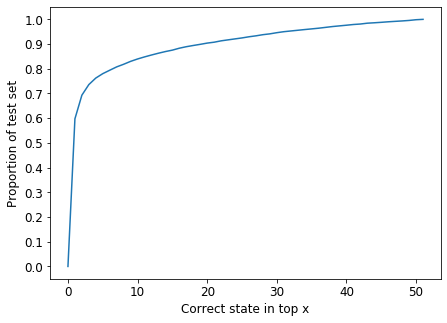

In [96]:
print(tops)

frac_tops = [0]
frac_tops.extend(tops/len(l))
print(frac_tops)

plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams.update({'font.size': 12})

print(len(frac_tops), len(range(0,52)))
plt.plot(range(0,52), frac_tops)
plt.ylabel("Proportion of test set")
plt.xlabel("Correct state in top x")
plt.yticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [114]:
# mean error dist

center_dict = pickle.load(open("center_dict.p", "rb"))
print(center_dict)


cali_preds = []
ind_preds = []

errs = []

total_dist = 0
for i in range(len(y_pred)):
    pred_state = np.argmax(y_pred[i])
    label = l[i].item()
        
    pred_coord = center_dict[constants.states[pred_state]]
    act_coord = center_dict[constants.states[label]]
    
    if(constants.states[label] == "California"):
        cali_preds.append(constants.states[pred_state])
    elif(constants.states[label] == "Indiana"):
        ind_preds.append(constants.states[pred_state])
    
    
    err = geodesic(pred_coord, act_coord).miles
    errs.append(err)
    #print("Error of %f" % err)
    total_dist += err
    
print("Average distance error of %f" % (total_dist/len(y_pred)))

{'Alaska': (64.4459613, -149.680909), 'Alabama': (33.2588817, -86.8295337), 'Arkansas': (35.2048883, -92.4479108), 'Arizona': (34.395342, -111.7632755), 'California': (36.7014631, -118.7559974), 'Colorado': (38.7251776, -105.6077167), 'Connecticut': (41.6500201, -72.7342163), 'District of Columbia': (38.89379365, -76.98799757261312), 'Delaware': (38.6920451, -75.4013315), 'Florida': (27.7567667, -81.4639835), 'Georgia': (32.3293809, -83.1137366), 'Hawaii': (19.58726775, -155.42688965312746), 'Iowa': (41.9216734, -93.3122705), 'Idaho': (43.6447642, -114.0154071), 'Illinois': (40.0796606, -89.4337288), 'Indiana': (40.3270127, -86.1746933), 'Kansas': (38.27312, -98.5821872), 'Kentucky': (37.5726028, -85.1551411), 'Louisiana': (30.8703881, -92.007126), 'Massachusetts': (42.3788774, -72.032366), 'Maryland': (39.5162234, -76.9382069), 'Maine': (45.709097, -68.8590201), 'Michigan': (43.6211955, -84.6824346), 'Minnesota': (45.9896587, -94.6113288), 'Missouri': (38.7604815, -92.5617875), 'Missi

0.0


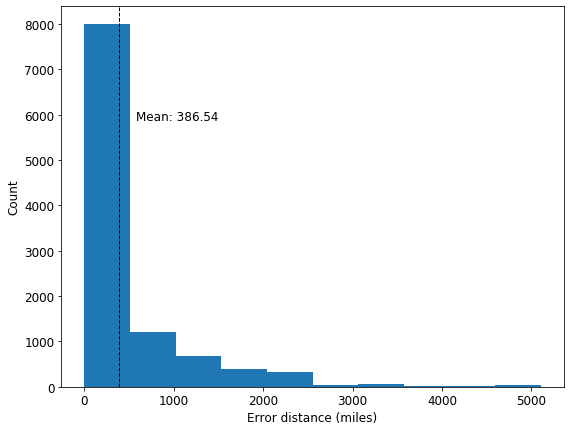

In [136]:
plt.rcParams['figure.figsize'] = [9, 7]
plt.hist(errs, bins = 10)
plt.ylabel("Count")
plt.xlabel("Error distance (miles)")
plt.axvline(np.mean(errs), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(errs)*1.5, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(errs)))

print(np.median(errs))